# 霍夫变换

hough transform，是一种用于检测形状的图像处理技术。

如何令机器自动的去检测图像中的直线、或圆，是霍夫变换的基本功能



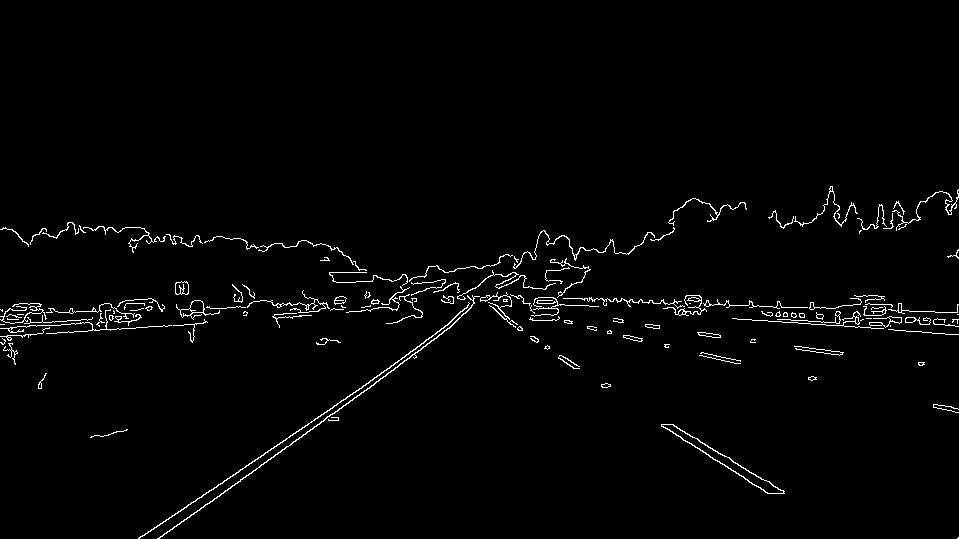

### 从直线检测开始说起

给定一张图像，如何从中检测出所有直线？

In [2]:
import cv2
import matplotlib.pyplot as plt

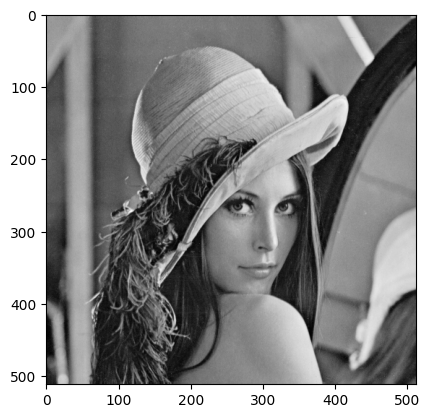

In [4]:
img = cv2.imread("../../dataset/lena.png", 0)
plt.imshow(img, cmap='gray')
plt.show()

```
一种简单的思路就是：

任取两点

计算两点的直线方程

看这张图像中的散点处于这条直线方程上是否重合的够多

如果够多，则是一条直线

遍历上述过程，则能够检测出所有的直线。

```

显然，上述方法中的计算复杂度极高，对于较大的图像，或较复杂的内容，则效率极低。

**霍夫变换**则是用于提高检测效率的重要手段。

### 霍夫坐标系

已知一个直线的方程为

$$y=kx+b$$

其中，$k,b$是参数，$x,y$是变量

对于点$A(x_1, y_1)$, 点$B=(x_2, y_2)$，有

$$y_1 = k x_1 + b$$
$$y_2 = k x_2 + b$$


将参数和变量交换，将$x,y$视为参数，$k,b$视为变量，则可以写为

$$q = -k x_1 + y_1$$
$$q = -k x_2 + y_2$$

下图即为两种坐标系的直观描述

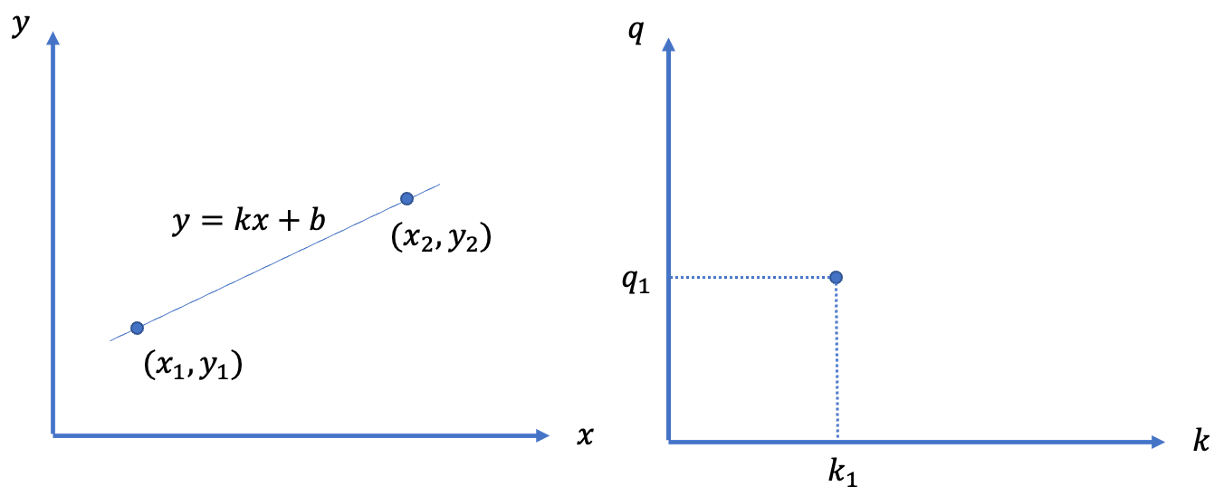

从上图中可以得到一条重要结论：

**笛卡尔坐标系中的一条线，变换到霍夫空间后，是一个点**

那么笛卡尔坐标系中的一个点，变换到霍夫空间后是什么？

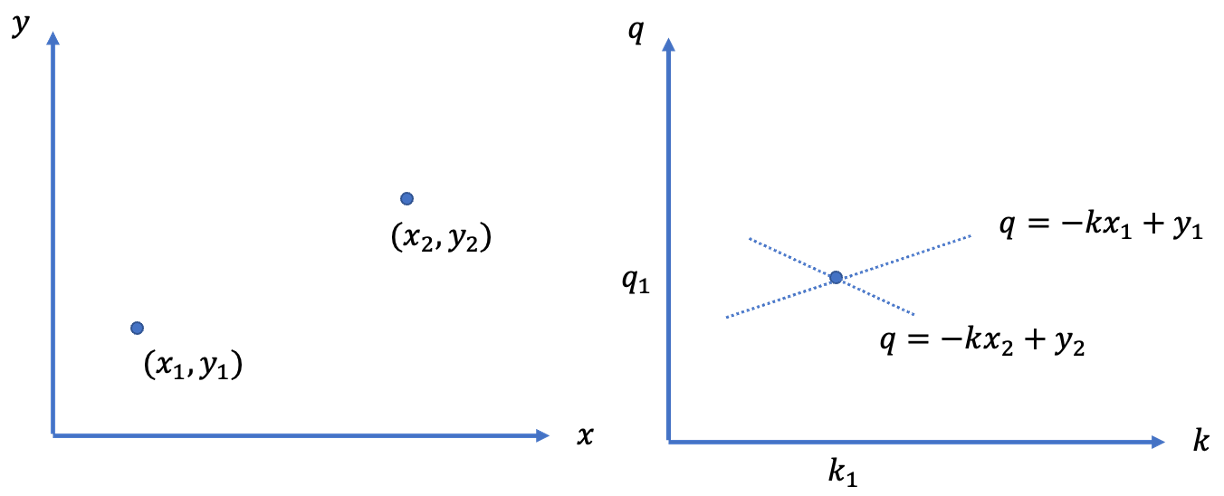

问题1: 那么要是三点共线，是什么情形？

问题2: 那么要是四点共两线，是什么情形？

**上述坐标系中的一个关键缺陷**

如果是一条垂直于x轴的直线，在霍夫空间中如何表示？

因此，需要引入极坐标系。

即坐标系用角度和幅度来表示点的坐标。

即：

$$x_1 = \rho\cos(\theta)$$
$$y_1 = \rho\sin(\theta)$$

上式合并后，即可得到

$$x_1\cos(\theta)+y_1\sin(\theta)=\rho$$

将极坐标转化成霍夫空间

思考点、线在霍夫空间中的表示。

### 如何检测直线？

显然，当任意两个点在霍夫空间的映射的线条中，函数必然必有一点相交

相交的这个点，就是直线的坐标方程。

那么对于一组点来说，相交的最多的点，就是穿越了这些散点的方程，即这条直线方程经过了最多的像素点。

因此，这条直线的参数，是图像中的一条主要直线。

一个简单的演示示例

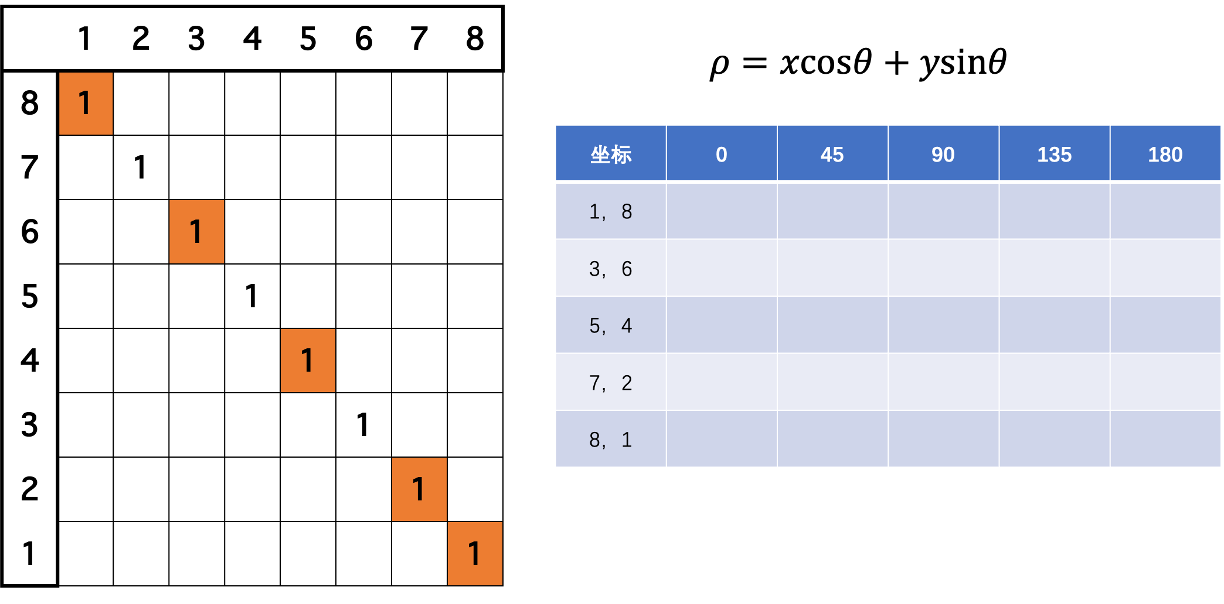

由上述过程，可以得到霍夫变换检测直线的基本步骤：

* 取若干个散点
* 遍历所有角度，计算$\rho$
* 对$\rho$的数值进行投票，当票数大于设定阈值时，则认为是一条直线

以下从代码角度来实现单条直线的目标检测

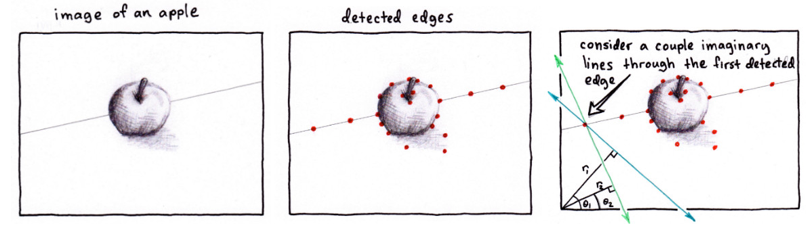

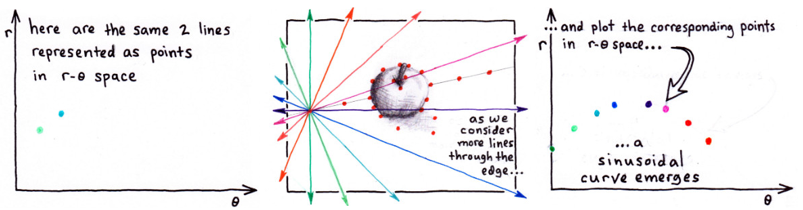
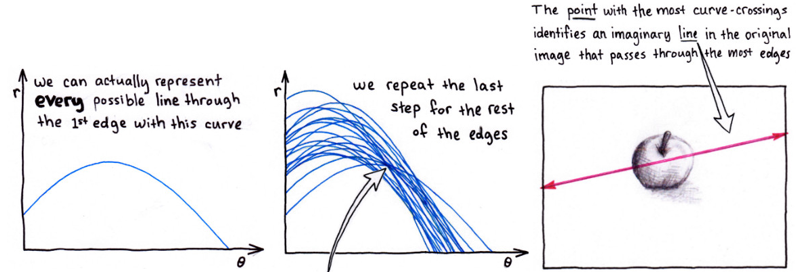

opencv提供了专用的接口，来实现hough检测。

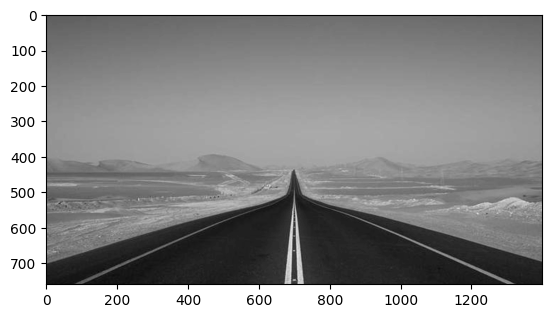

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取图像
img = cv2.imread('../../dataset/line.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.show()

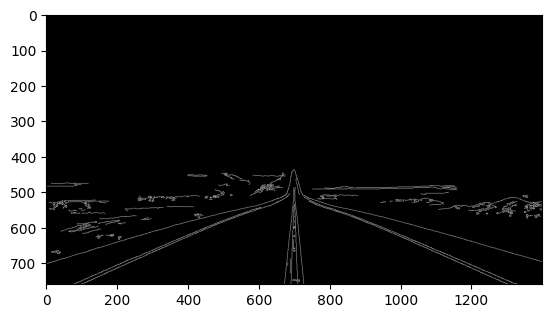

In [13]:
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
plt.imshow(edges, cmap='gray')

In [14]:
# 构建霍夫空间并检测
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
print(lines.shape)

(9, 1, 2)


In [17]:
# 绘制直线
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 +  1000 * (-b))
    y1 = int(y0 +  1000 * (a))
    x2 = int(x0 -  1000 * (-b))
    y2 = int(y0 -  1000 * (a))
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

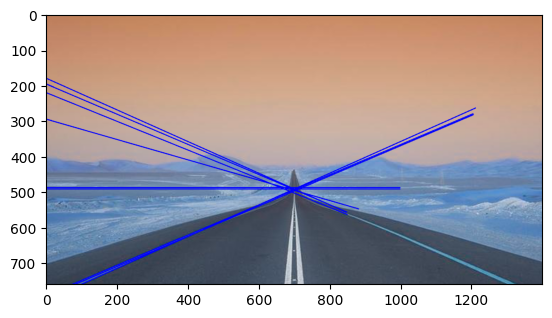

In [18]:
plt.imshow(img)
plt.show()

### 课堂练习2

检测出图中的高压电线

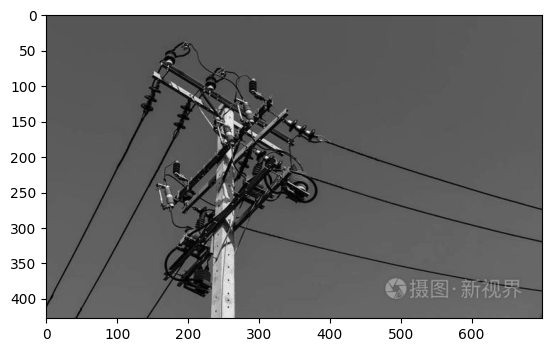

In [169]:
import cv2
import numpy as np

img = cv2.imread('../../dataset/wireline.jpeg',0)
plt.imshow(img, cmap='gray')
plt.show()

那么进一步的，霍夫变换出了检测直线，如何实现圆形检测？

### 霍夫圆检测

在笛卡尔坐标系下，圆方程为：

$$(x-a)^2 + (y-b)^2=r^2$$

在极坐标下，圆的方程为：

$$a = x - r\cos\theta$$
$$b = y - r\sin\theta$$

也就是说，在三维坐标下，$(a, b, r)$表示一个半径为r，通过坐标点$(x, y)$的圆

也就是说，圆检测中的霍夫变换则变成了一个三维空间，坐标轴分别为$a, b, r$

如果在三维霍夫空间中，曲线相交于一点，则说明在该点的(a, b, r)共圆

那么我们只需要统计在三维霍夫空间中共点的数量，就可以找到圆形

然而，上述方法在三维空间上进行，其复杂度是$O(n^3)$

opencv则采用了梯度法估计圆心，从而实现计算复杂度的优化。

### 霍夫梯度法

基本思路：遍历累加所有非零点对应的圆心。

如何找到圆心？

圆心，一定处于，垂直于该点，并且经过该点的切线的垂线上。

而霍夫梯度法则是通过查找圆心，根据圆心上相交的数量多少，来确定相交数量。

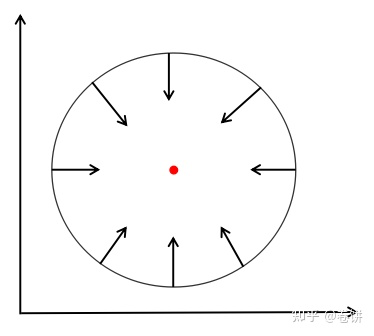

总体上，算法可以分为两个步骤，即

* 找圆心
* 统计半径

如何找圆心？

对于每个点进行梯度计算

对于每个非零点，沿梯度方向画线

设定好线段长度，我们就可以得到指定线段，并且可以统计他们的相交情况

相交数量超过一定值，则认为是一个圆心。

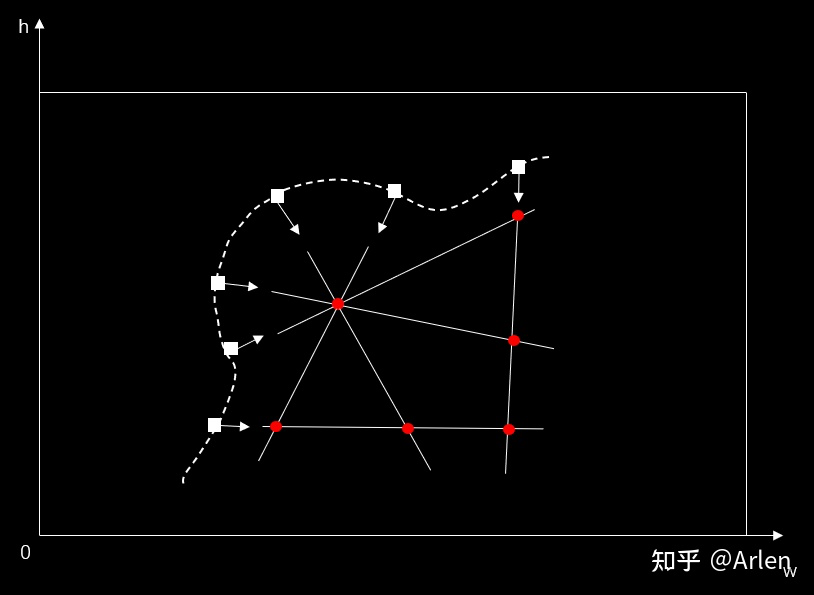

确定了圆心后，半径也随之被确定，就是哪个区间段的线段长度相交最多，则为半径。/

通常，霍夫圆变换有opencv提供的api

In [170]:
import cv2
import numpy as np

img = cv2.imread('../../dataset/car.png',0)
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
print(img.shape)

(573, 1100)


In [171]:
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT_ALT, 1, 10, param1=100, param2=0.9, minRadius=20, maxRadius=300)
print(circles.shape)

(1, 5, 3)


In [172]:
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

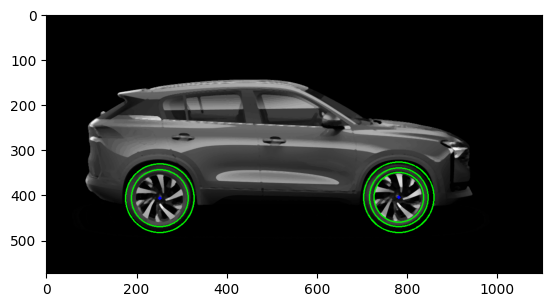

In [173]:
plt.imshow(cimg)
plt.show()

`circles = cv2.HoughCircles(image, method, dp, minDist, circles, param1, param2, minRadius, maxRadius)`

* img: 目标函数
* method: 
    - cv2.HOUGH_GRADIENT  梯度检测
    - cv2.HOUGH_GRADIENT_ALT 投票检测
* dp: 分辨率，通常为1
* minDist: 圆心的最小距离
* circle: 输出
* param1: 梯度参数
* param2: 圆心阈值
* minRadius: 最小圆心
* maxRadius: 最大圆心

#### 课堂练习2

检测出圆形硬币，要求每个硬币检测出一个圆


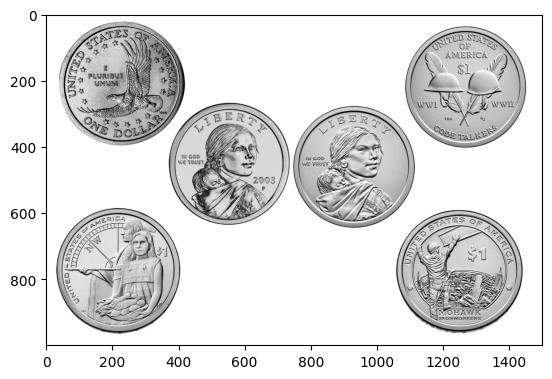

In [174]:
import cv2
import numpy as np

img = cv2.imread('../../dataset/coin.jpeg',0)
plt.imshow(img, cmap='gray')
plt.show()